# Model (ResNet) - Binary

Within this model, we'll use the same VGG16 model, but reduce the options down to 'Subuaru' and 'Not Subaru'

### Library Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random
import cv2
import copy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms



from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

from keras.applications import VGG16
from keras.applications.resnet import ResNet152
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10

from tensorflow import keras
from keras.utils import to_categorical
from keras import regularizers
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.losses import binary_crossentropy

from scipy.stats import skew
from tqdm import tqdm
from PIL import Image
from sklearn import metrics


### Data Augmentation

In [2]:
# #Remove comment to run again
# datagen = ImageDataGenerator(
#     rotation_range=20,
# #     width_shift_range=0.15,
# #     height_shift_range=0.15,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False,
# #     fill_mode='nearest'
# )

In [3]:
# image_dir = "Datasets/BoundingBoxes/"

# for root, dirs, files in os.walk(image_dir):
#     for filename in files:
#         if not filename.startswith('.'):
#             if os.path.basename(root).startswith('subaru'):
#                 filepath = os.path.join(root, filename)
#                 # load the image and convert it to a numpy array
#                 img = load_img(filepath)
#                 img_array = img_to_array(img)
#                 # reshape the array to have an extra dimension
#                 img_array = img_array.reshape((1,) + img_array.shape)
#                 # generate X (in range) augmented images and save them
#                 for i in range(4):
#                     aug_img_array = datagen.flow(img_array, batch_size=1)[0]
#                     aug_img = aug_img_array.astype('uint8')
#                     new_filename = f"{filename.split('.')[0]}_aug{i}.jpg"
#                     new_filepath = os.path.join(root, new_filename)
#                     # save the augmented image
#                     Image.fromarray(aug_img.squeeze()).save(new_filepath)
#                     print(f"New file created: {new_filepath}")

### Generator (Data Generator)

In [4]:
image_dir = "Datasets/BoundingBoxes/"

In [5]:
def image_data_generator(image_dir, batch_size):
    images = []
    labels = []
    for brand_dir in os.listdir(image_dir):
        if not brand_dir.startswith('.'):
            for filename in os.listdir(os.path.join(image_dir, brand_dir)):
                if not filename.startswith('.'):
                    label = brand_dir
                    filepath = os.path.join(image_dir, brand_dir, filename)
                    image = cv2.imread(filepath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224))
                    images.append(image)
                    labels.append(label)
                    if len(images) == batch_size:
                        labels = np.array(labels)
                        labels = np.where(np.array([label.split('_')[0] for label in labels]) == 'subaru', 1, 0)
                        yield np.array(images), np.array(labels)
                        images = []
                        labels = []
    if len(images) > 0:
        labels = np.array(labels)
        labels = np.where(np.array([label.split('_')[0] for label in labels]) == 'subaru', 1, 0)
        yield np.array(images), np.array(labels)

In [6]:
all_images = []
all_labels = []

for batch_images, batch_labels in image_data_generator(image_dir, batch_size=50000):
    all_images.append(batch_images)
    all_labels.append(batch_labels)

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [7]:
len(all_labels)

207368

In [8]:
1-(sum(all_labels)/len(all_labels)) ## baseline

0.6115601249951776

In [9]:
num_classes = len(np.unique(all_labels))
num_classes

2

### Train Test Split

To Train-Test split the data, we'll be seperating X on index to prevent all of the data from being loaded into the kernel concurrently.

In [10]:
idx = np.arange(len(all_images))
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=all_labels)

In [11]:
X_train, y_train = all_images[train_idx], all_labels[train_idx]

In [12]:
X_test, y_test = all_images[test_idx], all_labels[test_idx]

In [13]:
# y_train = np.reshape(y_train, (-1, 1))
# y_test = np.reshape(y_test, (-1, 1))

In [14]:
len(y_test)

41474

In [15]:
print('Subaru count:', np.sum(y_train))
print('Other count:', np.sum(1 - y_train))

Subaru count: 64440
Other count: 101454


### Data Generators

We'll feed our data into the model in batches of 32 so that all images aren’t loaded into the kernel at the same time. Within this function, we'll divide X_low by 255, to normalize the data.

This operation is split into two seperate generators to prevent data leakage from the training set into the validation set. Since the function has been seperated, each function will only be called when needed.

In [16]:
def train_data_generator(X_train, y_train, batch_size):
    num_train_samples = len(X_train)
    train_indices = np.arange(num_train_samples)
    np.random.shuffle(train_indices)

    while True:
        for start_idx in range(0, num_train_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_train_samples)
            batch_indices = train_indices[start_idx:end_idx]
            X_batch_train = torch.tensor(X_train[batch_indices], dtype=torch.float32)
            y_batch_train = torch.tensor(y_train[batch_indices], dtype=torch.long)

#             # Normalize the input data to [0, 1]
#             X_batch_train /= 255.0

            yield X_batch_train, y_batch_train

In [17]:
def test_data_generator(X_test, y_test, batch_size):
    num_test_samples = len(X_test)
    test_indices = torch.randperm(num_test_samples)
    while True:
        for start_idx_test in range(0, num_test_samples, batch_size):
            end_idx_test = min(start_idx_test + batch_size, num_test_samples)
            batch_indices_test = test_indices[start_idx_test:end_idx_test]
            batch_X_test = torch.tensor(X_test[batch_indices_test], dtype=torch.float32)
            batch_y_test = torch.tensor(y_test[batch_indices_test], dtype=torch.long)
            yield batch_X_test, batch_y_test

In [18]:
batch_size = 32
train_generator = train_data_generator(X_train, y_train, batch_size)
val_generator = test_data_generator(X_test, y_test, batch_size)

In [19]:
train_steps = len(X_train) // batch_size
val_steps = len(X_test) // batch_size

### Instantiating VGG16 Model (TensorFlow)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics=['accuracy']
epochs = 50

In [42]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 19s 0us/step


In [43]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [44]:
model.compile(optimizer= optimizer,
              loss= loss_fn,
              metrics= metrics)

In [45]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)


In [46]:
model.fit(train_generator,
          epochs=50,
          validation_data=val_generator,
          callbacks=[early_stopping],
          steps_per_epoch=train_steps, 
          validation_steps=val_steps)

Epoch 1/50


2023-05-12 16:39:08.956387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5184/5184 [==============================] - ETA: 0s - loss: 1.8429 - accuracy: 0.8279

2023-05-12 16:44:51.557365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5184/5184 [==============================] - 426s 81ms/step - loss: 1.8429 - accuracy: 0.8279 - val_loss: 1.6169 - val_accuracy: 0.8636
Epoch 2/50
5184/5184 [==============================] - 416s 80ms/step - loss: 1.4853 - accuracy: 0.8579 - val_loss: 1.2034 - val_accuracy: 0.8820
Epoch 3/50
5184/5184 [==============================] - 415s 80ms/step - loss: 1.4040 - accuracy: 0.8672 - val_loss: 1.7208 - val_accuracy: 0.8379
Epoch 4/50
5184/5184 [==============================] - 418s 81ms/step - loss: 1.3674 - accuracy: 0.8738 - val_loss: 1.7193 - val_accuracy: 0.8351
Epoch 5/50
5184/5184 [==============================] - 418s 81ms/step - loss: 1.3531 - accuracy: 0.8768 - val_loss: 1.5548 - val_accuracy: 0.8529
Epoch 6/50
5184/5184 [==============================] - 421s 81ms/step - loss: 1.3480 - accuracy: 0.8797 - val_loss: 1.2469 - val_accuracy: 0.8823
Epoch 7/50
5184/5184 [==============================] - 416s 80ms/step - loss: 1.3052 - accuracy: 0.8830 - val_loss: 1.3140 - val

### PyTorch Model

* To do:
 - seperate train/test datasets
 - create pytorch dataloaders for each datasets like
 

In [ ]:
# Put them in a dictionary
dataloaders = {'train': train_data_generator, 'valid': test_data_generator}

In [ ]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 2)
        self.dropout = nn.Dropout2d(p=0.2)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5, device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                model_save_name = "resnetCars.pt"
                path = F"/content/drive/My Drive/{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_results, valid_results

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model, train_results, valid_results = train_model(model, criterion, optimizer, num_epochs=5)

### Gradient Tape

In [ ]:
y_train = np.hstack((y_train, 1 - y_train))
y_test = np.hstack((y_test, 1 - y_test))

In [ ]:
def train(model, optimizer, loss_fn, train_data_generator, X_train, y_train, batch_size, epochs):
    for epoch in range(epochs):
        epoch_loss = tf.Variable(0.0, dtype=tf.float32)
        epoch_accuracy = tf.Variable(0.0, dtype=tf.float32)
        batches = train_data_generator(X_train, y_train, batch_size)
        with tqdm(total=len(X_train)//batch_size) as pbar:
            for i, (X_batch_train, y_batch_train) in enumerate(batches):
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch_train, training=True)
                    batch_loss = loss_fn(y_batch_train, y_pred)
                gradients = tape.gradient(batch_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                batch_accuracy = accuracy_score(np.argmax(y_batch_train, axis=1), np.argmax(y_pred.numpy(), axis=1))
                epoch_loss.assign_add(tf.reduce_sum(batch_loss))
                epoch_accuracy.assign_add(batch_accuracy)
                pbar.update(1)
        epoch_loss = epoch_loss / (X_train.shape[0] // batch_size)
        epoch_accuracy = epoch_accuracy / (X_train.shape[0] // batch_size)
        print(f"Epoch {epoch + 1}: loss={epoch_loss}, accuracy={epoch_accuracy}")

In [ ]:
def test(model, loss_fn, test_data_generator, X_test, y_test, batch_size):

    # Initialize the loss and accuracy
    test_loss = 0.0
    test_accuracy = 0.0

    # Iterate over the batches in the test data generator
    for X_batch_test, y_batch_test in test_data_generator(X_test, y_test, batch_size):

        # Compute the predictions and loss for the batch
        y_pred = model(X_batch_test, training=False)
        batch_loss = loss_fn(y_batch_test, y_pred)

        # Compute the batch accuracy
        batch_accuracy = accuracy_score(np.argmax(y_batch_train.numpy(), axis=1), np.argmax(y_pred.numpy(), axis=1))

        # Update the test loss and accuracy
        test_loss += batch_loss.numpy()
        test_accuracy += batch_accuracy

    # Compute the average test loss and accuracy
    test_loss /= (len(X_test) / batch_size)
    test_accuracy /= (len(X_test) / batch_size)

    # Print the test loss and accuracy
    print("Test loss: {:.4f} - Test accuracy: {:.4f}".format(test_loss, test_accuracy))

    return test_loss, test_accuracy

In [ ]:
train(model, optimizer, binary_crossentropy, train_data_generator, X_train, y_train, batch_size, epochs)

In [ ]:
tf.keras.backend.clear_session()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(
    train_data_generator(X_train, y_train, batch_size),
    validation_data=test_data_generator(X_test, y_test, batch_size),
    epochs=epochs, 
    steps_per_epoch=train_steps, 
    validation_steps=val_steps,
    callbacks=[early_stopping, tensorboard_callback]
)

In [ ]:
test_loss, test_acc = test(model, loss_fn, test_data_generator, X_test, y_test, batch_size)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)
y_pred_prob = model.predict(X_test)

threshold = 0.6

# Classify examples based on the threshold
y_pred = np.where(y_pred_prob > threshold, 1, 0)

1297/1297 [==============================] - 67s 50ms/step


In [51]:
# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.4571002892115334
Recall: 0.971260086902545
Accuracy: 0.5407484206973043


<Axes: >

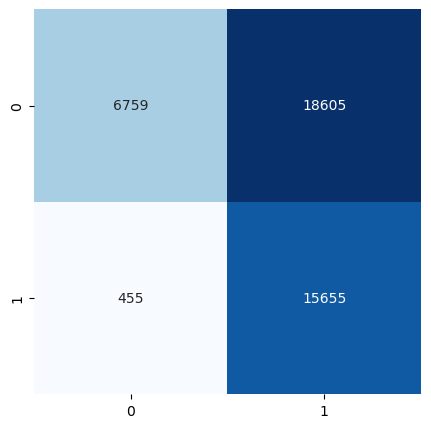

In [52]:
cm = confusion_matrix(y_test, y_pred_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

In [53]:
cm

array([[ 6759, 18605],
       [  455, 15655]])

In [54]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

In [55]:
accuracy, precision, recall, f1_score

(0.5404349713073251,
 0.45694687682428486,
 0.9717566728739913,
 0.6216001588246973)

In [ ]:
### Model results

1) ResNet150 Model
    - bounding boxes with multiple augmentations completed for subaru images
    - acc,prec,recall,f1_score (0.5754930800019289,0.47765162832387215,0.9923649906890131,0.6448971359419121)
    - baseline .625 (base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    - converges to .999999 accuracy on model, .989 validation